# HDFC Stock — Exploratory Data Analysis

**Dataset:** HDFC stock OHLC + volume (columns: Date, Symbol, Series, Prev Close, Open, High, Low, Last, Close, VWAP, Volume, Turnover, Trades, Deliverable Volume, %Deliverble)

## Summary (TL;DR)
- Period analyzed: YYYY-MM-DD → YYYY-MM-DD
- Key findings:
  1. X — short sentence about trend/seasonality.
  2. Y — relation between VWAP and Close / volume effects.
  3. Z — distribution of returns / notable volatility.

## What I did
- Data cleaning & parsing
- Feature engineering: returns, log returns, rolling MA, volatility
- Visualizations: timeseries, volume, histograms, correlations, drawdowns
- Exported key charts to `/images/`

## How to run
1. `pip install -r requirements.txt`
2. Place `hdfc.csv` in the repository root
3. Open `hdfc_eda.ipynb` and run all cells

## Next steps
- Forecast with ARIMA / Prophet / LightGBM
- Build a simple momentum/backtest strategy


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set_theme(style='whitegrid')
%matplotlib inline


In [8]:

df = pd.read_csv('data/HDFC.csv', parse_dates=['Date'])
df = df.sort_values('Date').reset_index(drop=True)
# df.head(10)
# df.tail(10)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5306 entries, 0 to 5305
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                5306 non-null   datetime64[ns]
 1   Symbol              5306 non-null   object        
 2   Series              5306 non-null   object        
 3   Prev Close          5306 non-null   float64       
 4   Open                5306 non-null   float64       
 5   High                5306 non-null   float64       
 6   Low                 5306 non-null   float64       
 7   Last                5306 non-null   float64       
 8   Close               5306 non-null   float64       
 9   VWAP                5306 non-null   float64       
 10  Volume              5306 non-null   int64         
 11  Turnover            5306 non-null   float64       
 12  Trades              2456 non-null   float64       
 13  Deliverable Volume  4797 non-null   float64     

In [9]:
# df["Date"] = pd.to_datetime(df["Date"])

In [10]:
df["%Deliverble"]

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
         ...  
5301    0.6232
5302    0.5100
5303    0.5327
5304    0.4901
5305    0.6372
Name: %Deliverble, Length: 5306, dtype: float64

In [15]:
df.rename(columns={"%Deliverble":"PctDeliverble"},inplace=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5306 entries, 0 to 5305
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                5306 non-null   datetime64[ns]
 1   Symbol              5306 non-null   object        
 2   Series              5306 non-null   object        
 3   Prev Close          5306 non-null   float64       
 4   Open                5306 non-null   float64       
 5   High                5306 non-null   float64       
 6   Low                 5306 non-null   float64       
 7   Last                5306 non-null   float64       
 8   Close               5306 non-null   float64       
 9   VWAP                5306 non-null   float64       
 10  Volume              5306 non-null   int64         
 11  Turnover            5306 non-null   float64       
 12  Trades              2456 non-null   float64       
 13  Deliverable Volume  4797 non-null   float64     

In [17]:
df.describe()

,Date,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,PctDeliverble
count,5306,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5.306000e+03,5.306000e+03,2456.000000,4.797000e+03,4797.000000
mean,2010-08-18 21:26:56.132679936,1283.666114,1284.393074,1304.269732,1263.297842,1283.885017,1284.071005,1283.664578,1.848187e+06,2.620759e+14,102159.051303,1.329440e+06,0.653088
min,2000-01-03 00:00:00,271.750000,284.000000,290.500000,273.250000,282.850000,283.850000,283.600000,2.919000e+03,1.834686e+11,973.000000,1.786000e+03,0.119000
25%,2005-04-13 12:00:00,668.650000,669.712500,677.512500,660.000000,669.000000,668.662500,668.265000,3.034970e+05,2.461178e+13,62011.500000,2.688070e+05,0.575200
50%,2010-08-17 12:00:00,1136.275000,1135.400000,1156.725000,1119.000000,1135.000000,1136.675000,1136.720000,1.337788e+06,1.684207e+14,90405.000000,1.021574e+06,0.666900
75%,2015-12-17 18:00:00,1811.475000,1813.812500,1835.000000,1783.075000,1812.000000,1811.787500,1811.680000,2.732310e+06,3.419282e+14,129754.500000,1.939101e+06,0.742000
max,2021-04-30 00:00:00,3180.150000,3148.000000,3262.000000,3100.550000,3178.000000,3180.150000,3166.580000,1.584141e+08,1.043773e+16,538170.000000,1.483131e+08,0.989400
std,NaN,709.395090,709.703665,721.308080,697.450309,709.250204,709.430515,709.109622,2.991387e+06,3.607844e+14,57948.603200,2.555073e+06,0.128115


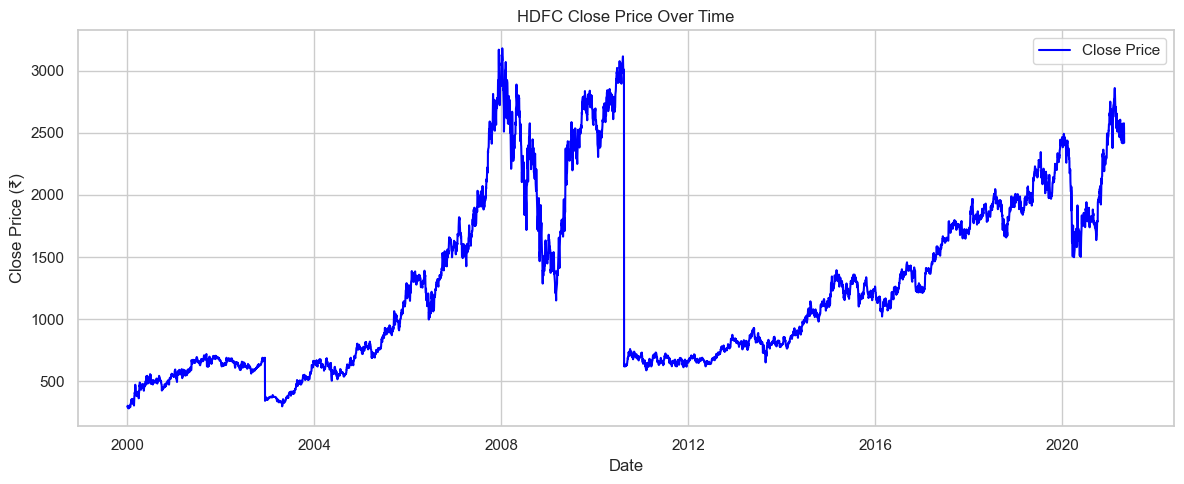

In [20]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Close'], color='blue', label='Close Price')
plt.title('HDFC Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price (₹)')
plt.legend()
plt.tight_layout()
plt.show()


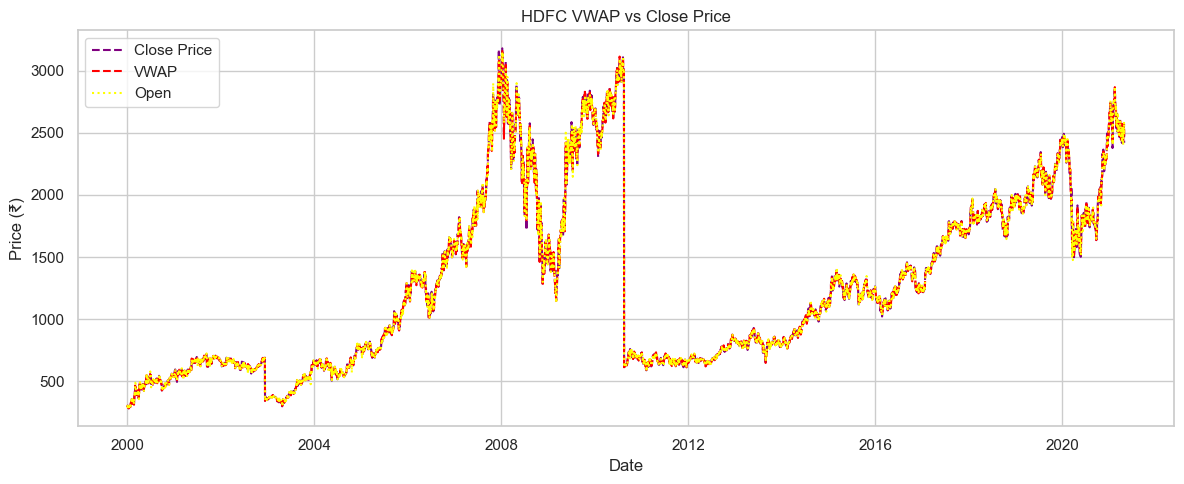

In [27]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Close'], label='Close Price', color='purple',linestyle="dashed")
plt.plot(df['Date'], df['VWAP'], label='VWAP', color='red', linestyle='--')
plt.plot(df['Date'], df['Open'], label='Open', color='yellow', linestyle='dotted')
plt.title('HDFC VWAP vs Close Price')
plt.xlabel('Date')
plt.ylabel('Price (₹)')
plt.legend()
plt.tight_layout()
plt.show()


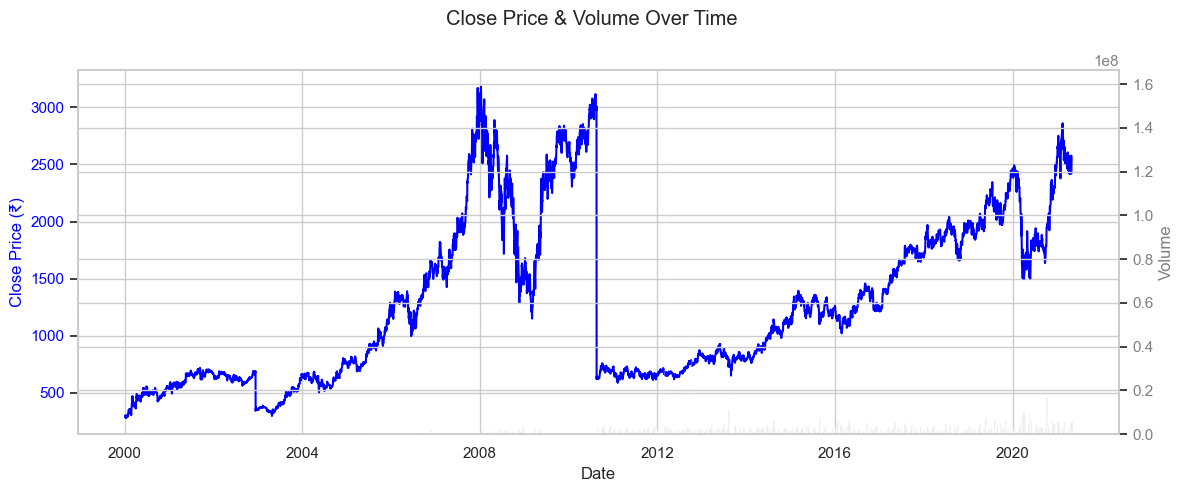

In [22]:
fig, ax1 = plt.subplots(figsize=(12,5))

# Close Price (line)
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price (₹)', color='blue')
ax1.plot(df['Date'], df['Close'], color='blue', label='Close')
ax1.tick_params(axis='y', labelcolor='blue')

# Volume (bar on secondary y-axis)
ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='gray')
ax2.bar(df['Date'], df['Volume'], color='gray', alpha=0.3, label='Volume')
ax2.tick_params(axis='y', labelcolor='gray')

# Title and layout
fig.suptitle('Close Price & Volume Over Time')
fig.tight_layout()
plt.show()


In [28]:
# 1. Create the figure & first axis
# python
# Copy
# Edit
# fig, ax1 = plt.subplots(figsize=(12,5))
# plt.subplots() → Creates a figure (fig) and one axis (ax1) to draw on.

# figsize=(12,5) → Sets the width to 12 inches and height to 5 inches.

# Now ax1 is our main y-axis for the Close Price.

# 2. Configure first axis (Close Price)
# python
# Copy
# Edit
# ax1.set_xlabel('Date')
# ax1.set_ylabel('Close Price (₹)', color='blue')
# set_xlabel → Labels the X-axis as "Date".

# set_ylabel → Labels the Y-axis for ax1 as "Close Price (₹)" and makes the label text blue (to match the line color later).

# 3. Plot Close Price on first axis
# python
# Copy
# Edit
# ax1.plot(df['Date'], df['Close'], color='blue', label='Close')
# ax1.plot() → Plots a line chart.

# df['Date'] → X-axis (dates).

# df['Close'] → Y-axis values (close prices).

# color='blue' → Makes the line blue.

# label='Close' → Stores the label for a legend (not shown yet).

# 4. Make the y-axis labels blue
# python
# Copy
# Edit
# ax1.tick_params(axis='y', labelcolor='blue')
# Makes the Y-axis tick labels (numbers) the same color as the line — easier to read.

# 5. Create secondary y-axis for Volume
# python
# Copy
# Edit
# ax2 = ax1.twinx()
# twinx() → Creates a new y-axis on the right side that shares the same X-axis as ax1.

# This allows us to plot Volume without mixing its scale with Close Price (because Volume numbers are huge compared to price).

# 6. Configure secondary y-axis (Volume)
# python
# Copy
# Edit
# ax2.set_ylabel('Volume', color='gray')
# Adds the Y-axis label "Volume" in gray (matching bar color).

# 7. Plot Volume as bars
# python
# Copy
# Edit
# ax2.bar(df['Date'], df['Volume'], color='gray', alpha=0.3, label='Volume')
# ax2.bar() → Draws a bar chart.

# alpha=0.3 → Makes bars semi-transparent (so they don’t overpower the line).

# Bars will be aligned with dates, sharing the same X-axis as Close Price.

# 8. Make the right Y-axis ticks gray
# python
# Copy
# Edit
# ax2.tick_params(axis='y', labelcolor='gray')
# Makes Volume axis numbers gray.

# 9. Add title and adjust layout
# python
# Copy
# Edit
# fig.suptitle('Close Price & Volume Over Time')
# fig.tight_layout()
# suptitle → Adds a title above the entire figure.

# tight_layout() → Adjusts spacing so labels don’t overlap.

# 10. Display the chart
# python
# Copy
# Edit
# plt.show()
# Actually renders the figure in Jupyter.

# What’s happening visually
# Left Y-axis (blue) → Close Price (line chart).

# Right Y-axis (gray) → Volume (bar chart).

# X-axis → Date, shared by both.

# Transparency makes bars sit behind the line visually.

In [29]:
df['Return'] = df['Close'].pct_change()
# pct_change() in Pandas calculates the percentage change between the current row and a previous row (by default, the immediately previous one).

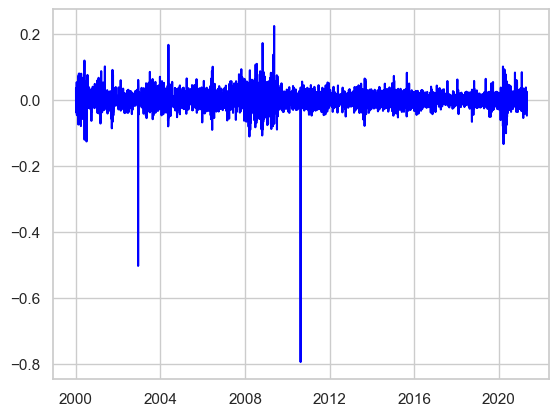

In [30]:
plt.plot(df["Date"],df["Return"],label="return on date",color="blue")
plt.show()

In [ ]:

df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))
# Log returns are just another way to measure changes in price — but instead of using a plain percentage change, they use the natural log of the price ratio between two periods.

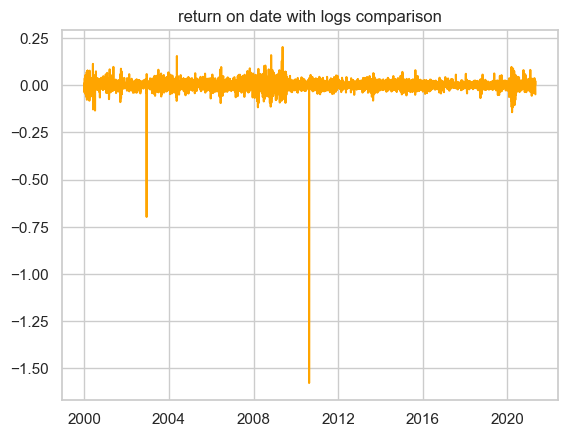

In [48]:
plt.plot(df["Date"],df["LogReturn"],label="return on date with logs comparison",color="orange")
plt.title("return on date with logs comparison")
plt.show()
# Log returns are preferred for big-duration analysis because they handle time aggregation and compounding much more cleanly than simple returns.

# Let’s break it down step-by-step:

# 1️⃣ Compounding problem with simple returns
# If you have:

# Day 1 return: +10%

# Day 2 return: −10%

# Simple return math:

# (1 + 0.10) \times (1 - 0.10) - 1 = -0.01 \ (\text{-1%})
# You can’t just do +10% − 10% = 0% because compounding is multiplicative, not additive.
# So over long periods, you need to keep multiplying all the daily returns — which becomes messy.

# 2️⃣ Additivity of log returns
# Log returns solve that mess:

# log return
# =
# ln
# ⁡
# (
# 𝑃
# 𝑡
# 𝑃
# 𝑡
# −
# 1
# )
# log return=ln( 
# P 
# t−1
# ​
 
# P 
# t
# ​
 
# ​
#  )
# For the same example:

# Day 1 log return: 
# ln
# ⁡
# (
# 1.10
# )
# =
# 0.09531
# ln(1.10)=0.09531

# Day 2 log return: 
# ln
# ⁡
# (
# 0.90
# )
# =
# −
# 0.10536
# ln(0.90)=−0.10536

# Over 2 days:

# \text{Total log return} = 0.09531 + (-0.10536) = -0.01005 \ (\text{-1%})
# ✅ You just add the daily log returns to get the total period return.

# This is a huge advantage when you’re:

# Summing hundreds of days of returns

# Doing portfolio-level analysis

# Modeling volatility over time



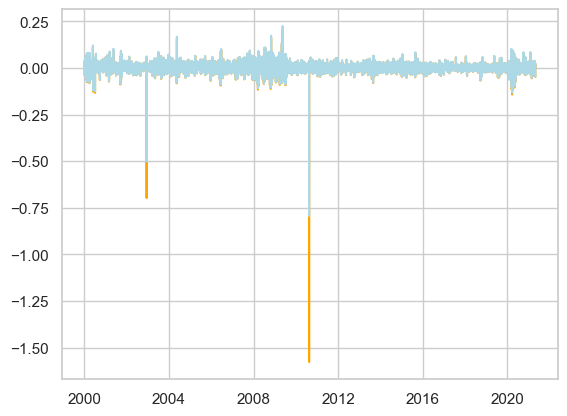

In [34]:
plt.plot(df["Date"],df["LogReturn"],label="return on date with logs comparison",color="orange")
plt.plot(df["Date"],df["Return"],label="return on date without logs comparison",color="lightblue")
plt.show()

In [ ]:
df['Intraday_Spread'] = (df['High'] - df['Low']) / df['Open']
# Intraday Spread is useful in analysis — especially in a Data Science (DS) role — because it’s a quick measure of volatility and liquidity within the same trading day.

# Let’s break it down:

# 1️⃣ What Intraday Spread means
# Formula:

# Intraday Spread
# =
# High
# −
# Low
# Open
# Intraday Spread= 
# Open
# High−Low
# ​
 
# It tells you how much the price fluctuated within the day relative to its opening price.

# Small spread → Price stayed stable → Low volatility day

# Large spread → Big swings between high & low → High volatility day



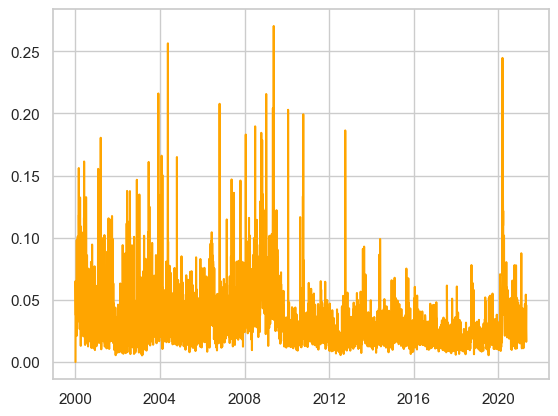

In [37]:
plt.plot(df["Date"],df["Intraday_Spread"],label="Intraday spread",color="Orange")
plt.show()

In [42]:
# High_Low_Range → Absolute range of the day.
# Close_Open_Change → Net movement from open to close.

df['High_Low_Range'] = df['High'] - df['Low']
df['Close_Open_Change'] = df['Close'] - df['Open']

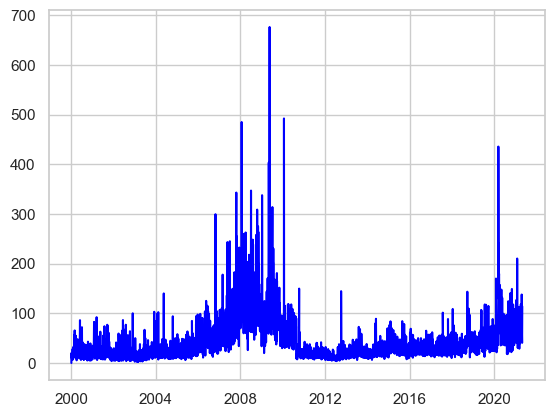

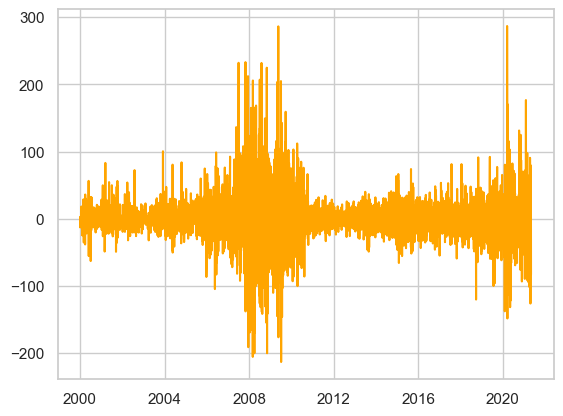

In [43]:
plt.plot(df["Date"],df["High_Low_Range"],label="High_Low_Range",color="Blue")
plt.show()

plt.plot(df["Date"],df["Close_Open_Change"],label="Close_Open_Change",color="Orange")
plt.show()

In [ ]:
# In the real world, moving averages (MA7, MA21, MA50, etc.) are used heavily in trading, investing, and quantitative finance — both by humans and algorithms — to understand trends, smooth out noise, and make decisions.

# Real-World Uses
# 1️⃣ Trend Identification
# Short MA (e.g., 7-day) above a long MA (e.g., 50-day) → Price is in an uptrend.
# Short MA below a long MA → Price is in a downtrend.

# Example: A trader sees MA7 > MA21 and might take a buy position.
# 2️⃣ Support & Resistance Levels
# Moving averages act as dynamic support or resistance lines.
# In stocks like Apple, if the price falls to the MA50 and bounces back, traders consider it a buying opportunity.

# 3️⃣ Golden Cross / Death Cross Signals
# Golden Cross → Short-term MA crosses above long-term MA → Bullish signal.
# Death Cross → Short-term MA crosses below long-term MA → Bearish signal.
# Hedge funds and algo-trading systems often use these signals as part of automated strategies.

# 4️⃣ Noise Reduction
# Prices move up and down daily due to random events (news, emotions, intraday volatility).
# Moving averages smooth out random noise so you can see the true direction.

# 5️⃣ Feature Engineering for Machine Learning
# In a Data Science role, these MAs are often included in datasets as features:
# MA7: Captures short-term momentum.
# MA21: Captures medium-term momentum.
# MA50: Captures long-term momentum.
# Models can combine these with other indicators (RSI, MACD, volatility measures) to predict future prices.


df['MA7']  = df['Close'].rolling(window=7).mean()
df['MA21'] = df['Close'].rolling(window=21).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()

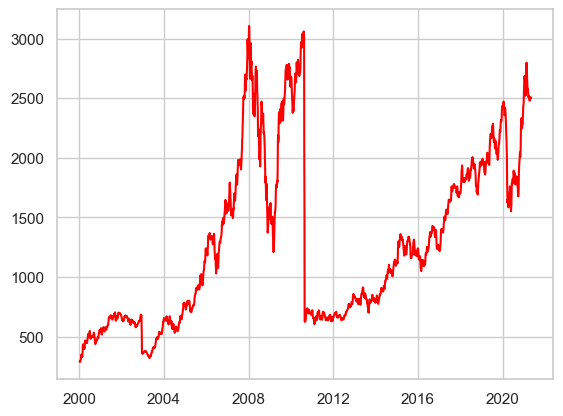

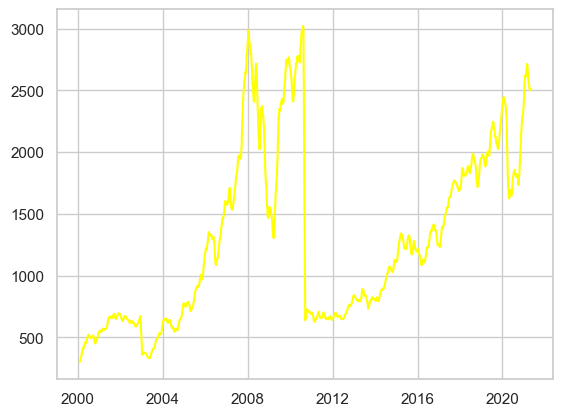

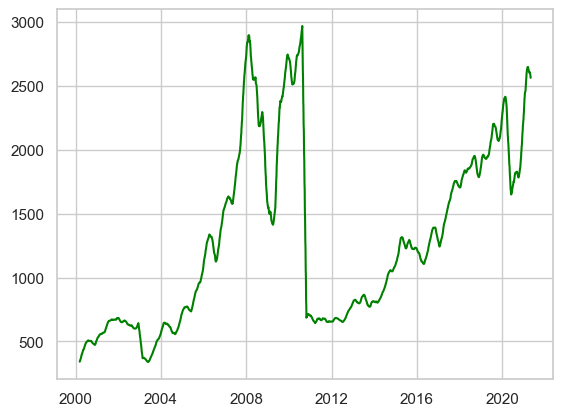

In [46]:
plt.plot(df["Date"],df["MA7"],label="Moving Average by 7 Days",color="red")
plt.show()

plt.plot(df["Date"],df["MA21"],label="Moving Average by 21 Days",color="Yellow")
plt.show()

plt.plot(df["Date"],df["MA50"],label="Moving Average by 50 Days",color="Green")
plt.show()


In [ ]:
# 6️⃣ Rolling volatility
# Measures variability of returns over a given period.

df['Volatility_7']  = df['Return'].rolling(window=7).std()
df['Volatility_21'] = df['Return'].rolling(window=21).std()

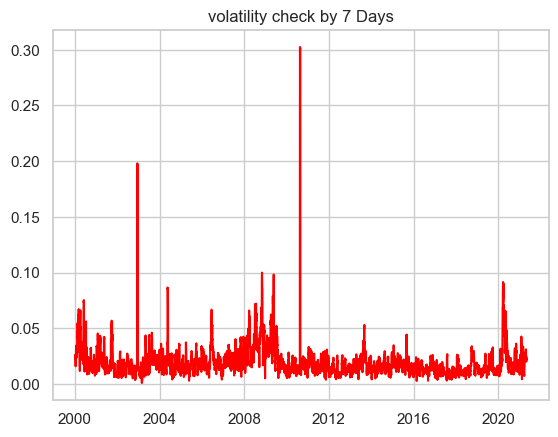

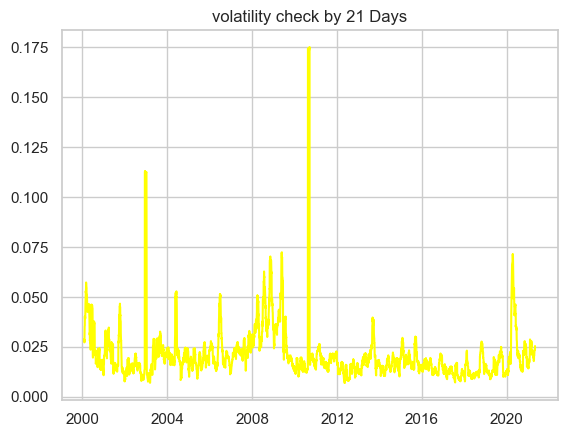

In [50]:
plt.plot(df["Date"],df["Volatility_7"],label="volatility check by 7 Days",color="red")
plt.title("volatility check by 7 Days")
plt.show()

plt.plot(df["Date"],df["Volatility_21"],label="volatility check by 21 Days",color="Yellow")
plt.title("volatility check by 21 Days")
plt.show()
